# 2: Observing the same object with multiple telescopes

A brief introduction into using ScopeSim to observe a cluster in the LMC using the 39m ELT and the 1.5m LFOA

*This is a step-by-step guide. The complete script can be found at the bottom of this page/notebook.*

First set up all relevant imports:

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import scopesim as sim
import scopesim_templates as sim_tp

Scopesim works by using so-called instrument packages, which have to be downloaded separately. For normal use, you would set the package directory (a local folder path, `local_package_folder` in this example), download the required packages *once*, and then **remove the download command**.

In [2]:
local_package_folder = "./inst_pkgs"

However, to be able to run this example on the *Readthedocs* page, we need to include a temporary directory.

**Do not** copy and run this code locally, it is **only** needed to set things up for *Readthedocs*!

In [3]:
from tempfile import TemporaryDirectory
local_package_folder = TemporaryDirectory().name

Download the packages for MICADO at the ELT and the viennese [1.5m telescope at the LFOA](https://foa.univie.ac.at/instrumentation/)

Again, you would only need to do this **once**, not every time you run the rest of the script, assuming you set a (permanent) instrument package folder.

In [4]:
sim.rc.__config__["!SIM.file.local_packages_path"] = local_package_folder
sim.download_packages(["Armazones", "ELT", "MICADO", "MAORY", "LFOA"])

['C:\\Users\\ghost\\AppData\\Local\\Temp\\tmp5sh4rx91\\Armazones.zip',
 'C:\\Users\\ghost\\AppData\\Local\\Temp\\tmp5sh4rx91\\ELT.zip',
 'C:\\Users\\ghost\\AppData\\Local\\Temp\\tmp5sh4rx91\\MICADO.zip',
 'C:\\Users\\ghost\\AppData\\Local\\Temp\\tmp5sh4rx91\\MAORY.zip',
 'C:\\Users\\ghost\\AppData\\Local\\Temp\\tmp5sh4rx91\\LFOA.zip']

## Create a star cluster ``Source`` object

Now, create a star cluster using the scopesim_templates package. You can ignore the output that is sometimes printed. The seed argument is used to control the random number generation that creates the stars in the cluster. If this number is kept the same, the output will be consistent with each run, otherwise the position and brightness of the stars is randomised every time.

In [5]:
cluster = sim_tp.stellar.clusters.cluster(mass=10000,        # Msun
                                          distance=50000,    # parsec
                                          core_radius=2,     # parsec
                                          seed=9001)         # random seed

## Observe with the [1.5m telescope at the LFOA](https://foa.univie.ac.at/instrumentation/)

<img src=https://foa.univie.ac.at/fileadmin/_processed_/csm_FOA-2_1e249577a3.jpg width=400, align=left>


In [6]:
lfoa = sim.OpticalTrain("LFOA")
lfoa.observe(cluster,
             properties={"!OBS.ndit": 10, "!OBS.ndit": 360},
             update=True)
hdus_lfoa = lfoa.readout()


Reason:  <class 'ValueError'> !OBS.instrument was not found in rc.__currsys__



## Observe the same ``Source`` with MICADO at the ELT

<img src=https://astro.univie.ac.at/fileadmin/user_upload/i_astro/Aktuelles-News/2021/The_E-ELT.jpeg width=400 align=left>

In [7]:
micado = sim.OpticalTrain("MICADO")
micado.cmds["!OBS.dit"] = 10
micado.cmds["!OBS.ndit"] = 360
micado.update()

micado.observe(cluster)
hdus_micado = micado.readout()

Plot up the results

Text(0.5, 1.0, '39m ELT')

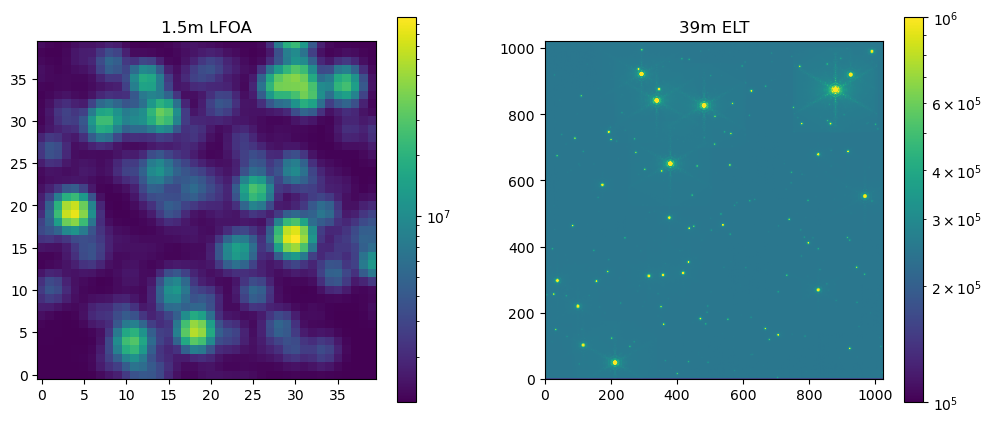

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(hdus_lfoa[0][1].data[345:385, 525:565], norm=LogNorm(), origin="lower")
plt.colorbar()
plt.title("1.5m LFOA")

plt.subplot(122)
plt.imshow(hdus_micado[0][1].data, norm=LogNorm(vmax=1E6, vmin=1e5), origin="lower")
plt.colorbar()
plt.title("39m ELT")

## Complete script

Included below is the complete script for convenience, including the downloads, but not including the plotting.

In [9]:
import scopesim as sim
import scopesim_templates as sim_tp

# sim.download_packages(["Armazones", "ELT", "MICADO", "MAORY", "LFOA"])

cluster = sim_tp.stellar.clusters.cluster(mass=10000,        # Msun
                                          distance=50000,    # parsec
                                          core_radius=2,     # parsec
                                          seed=9001)         # random seed

lfoa = sim.OpticalTrain("LFOA")
lfoa.observe(cluster,
             properties={"!OBS.ndit": 10, "!OBS.ndit": 360},
             update=True)
hdus_lfoa = lfoa.readout()

micado = sim.OpticalTrain("MICADO")
micado.cmds["!OBS.dit"] = 10
micado.cmds["!OBS.ndit"] = 360
micado.update()

micado.observe(cluster)
hdus_micado = micado.readout()



Reason:  <class 'ValueError'> !OBS.instrument was not found in rc.__currsys__

